<a href="https://colab.research.google.com/github/Tongxi-Hu/deep-learning/blob/main/d2l/7_1_deep_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7-1 Deep Convolutional Neural Networks


### 7-1-1 AlexNet


In [ ]:
!pip3 install d2l
import torch 
from torch import nn
from d2l import torch as d2l

In [4]:
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.activation import ReLU
from torch.nn.modules.linear import Linear
# 1*1*224*224->1*96*54*54->1*96*26*26->256*26*26->1*256*12*12->1*384*12*12*12
#->1*384*12*12->1*256*12*12->1*256*5*5->4094->4096->10
net=nn.Sequential(
    nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(96,256,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Conv2d(256,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,384,kernel_size=3,padding=1),nn.ReLU(),
    nn.Conv2d(384,256,kernel_size=3,padding=1),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2),nn.Flatten(),
    nn.Linear(6400,4096),nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(p=0.5),
    nn.Linear(4096,10)   
)

In [5]:
X=torch.randn(1,1,224,224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__, X.shape)

Conv2d torch.Size([1, 96, 54, 54])
ReLU torch.Size([1, 96, 54, 54])
MaxPool2d torch.Size([1, 96, 26, 26])
Conv2d torch.Size([1, 256, 26, 26])
ReLU torch.Size([1, 256, 26, 26])
MaxPool2d torch.Size([1, 256, 12, 12])
Conv2d torch.Size([1, 384, 12, 12])
ReLU torch.Size([1, 384, 12, 12])
Conv2d torch.Size([1, 384, 12, 12])
ReLU torch.Size([1, 384, 12, 12])
Conv2d torch.Size([1, 256, 12, 12])
ReLU torch.Size([1, 256, 12, 12])
MaxPool2d torch.Size([1, 256, 5, 5])
Flatten torch.Size([1, 6400])
Linear torch.Size([1, 4096])
ReLU torch.Size([1, 4096])
Dropout torch.Size([1, 4096])
Linear torch.Size([1, 4096])
ReLU torch.Size([1, 4096])
Dropout torch.Size([1, 4096])
Linear torch.Size([1, 10])


loss 0.407, train acc 0.850, test acc 0.857
425.6 examples/sec on cuda:0


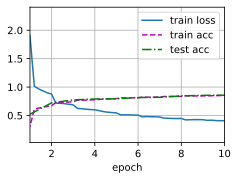

In [6]:
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=224)
lr,num_epochs=0.01,10
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

### 7-1-2 Networks Using Blocks (VGG)

In [10]:
import torch 
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs,in_channels,out_channels):
    layers=[]
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [11]:
conv_arch=((1,64),(1,128),(2,256),(2,512),(2,512))
def vgg(conv_arch):
    conv_blks=[]
    in_channels=1
    for (num_convs,out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
        in_channels=out_channels
    return nn.Sequential(*conv_blks,nn.Flatten(),
                         nn.Linear(out_channels*7*7,4096),nn.ReLU(),
                         nn.Dropout(0.5),nn.Linear(4096,4096),nn.ReLU(),
                         nn.Dropout(0.5),nn.Linear(4096,10))

In [13]:
net = vgg(conv_arch)
X=torch.randn(size=(1,1,224,224))
for blk in net:
    X=blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.172, train acc 0.937, test acc 0.911
362.4 examples/sec on cuda:0


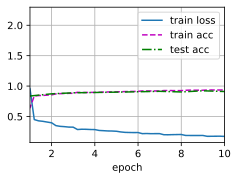

In [14]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 7-1-3 Network in Network (NiN)

In [17]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels,out_channels,kernel_size,strides,padding):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding),
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU())

In [18]:
net=nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # There are 10 label classes
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # Transform the four-dimensional output into two-dimensional output with a
    # shape of (batch size, 10)
    nn.Flatten())

In [19]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())